# KMeans with Native CUDA C++ - Comprehensive Analysis with Quality Metrics

This notebook implements the KMeans clustering algorithm using raw C++ and CUDA.

**Workflow:**
1.  **Python**: Load multiple datasets and save them to binary files.
2.  **C++ / CUDA**: Read the binary files, perform KMeans clustering on the GPU.
3.  **Bash**: Compile the CUDA program.
4.  **Python**: Run benchmarks with quality metrics (Silhouette Score) and create comprehensive visualizations.
5.  **K-Value Analysis**: Test different numbers of clusters to compare performance.

**Datasets:**
- Iris (150 samples, 4 features)
- Wine (178 samples, 13 features)
- Breast Cancer (569 samples, 30 features)
- Digits (1797 samples, 64 features)

## 1. Prepare Data (Python)

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import subprocess
import re
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
import os
import pandas as pd

# Create directory for datasets
os.makedirs('kmeans_datasets', exist_ok=True)

In [2]:
def prepare_kmeans_dataset(name, X, y, n_clusters):
    """Prepare and save a dataset for KMeans."""
    X = X.astype(np.float32)

    # Normalize data for better clustering
    scaler = StandardScaler()
    X = scaler.fit_transform(X).astype(np.float32)

    # Save to binary files
    prefix = f"kmeans_datasets/{name}"
    X.tofile(f"{prefix}_X.bin")

    # Save dimensions
    with open(f"{prefix}_dims.txt", "w") as f:
        f.write(f"{X.shape[0]} {X.shape[1]} {n_clusters}")

    print(f"{name}: Samples={X.shape}, Clusters={n_clusters}")

    return {
        'X': X,
        'y': y,  # True labels for validation
        'n_clusters': n_clusters
    }

# Load and prepare all datasets
kmeans_datasets = {}

# 1. Iris
iris = datasets.load_iris()
kmeans_datasets['iris'] = prepare_kmeans_dataset('iris', iris.data, iris.target, 3)

# 2. Wine
wine = datasets.load_wine()
kmeans_datasets['wine'] = prepare_kmeans_dataset('wine', wine.data, wine.target, 3)

# 3. Breast Cancer
cancer = datasets.load_breast_cancer()
kmeans_datasets['cancer'] = prepare_kmeans_dataset('cancer', cancer.data, cancer.target, 2)

# 4. Digits
digits = datasets.load_digits()
kmeans_datasets['digits'] = prepare_kmeans_dataset('digits', digits.data, digits.target, 10)

iris: Samples=(150, 4), Clusters=3
wine: Samples=(178, 13), Clusters=3
cancer: Samples=(569, 30), Clusters=2
digits: Samples=(1797, 64), Clusters=10


## 2. Implement KMeans in CUDA C++

This implementation uses Lloyd's algorithm with GPU acceleration and outputs cluster assignments for quality metrics.

In [3]:
%%writefile kmeans.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <sys/time.h>
#include <math.h>
#include <string.h>
#include <float.h>

#define BLOCK_SIZE 256
#define MAX_ITER 100

// Kernel to assign each point to nearest centroid
__global__ void assign_clusters(float *data, float *centroids, int *assignments,
                                 int n_samples, int n_features, int n_clusters) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < n_samples) {
        float min_dist = FLT_MAX;
        int best_cluster = 0;

        for (int c = 0; c < n_clusters; c++) {
            float dist = 0.0f;
            for (int f = 0; f < n_features; f++) {
                float diff = data[idx * n_features + f] - centroids[c * n_features + f];
                dist += diff * diff;
            }

            if (dist < min_dist) {
                min_dist = dist;
                best_cluster = c;
            }
        }

        assignments[idx] = best_cluster;
    }
}

// Update centroids on CPU
void update_centroids(float *data, int *assignments, float *centroids,
                      int n_samples, int n_features, int n_clusters) {
    memset(centroids, 0, n_clusters * n_features * sizeof(float));
    int *counts = (int*)calloc(n_clusters, sizeof(int));

    for (int i = 0; i < n_samples; i++) {
        int cluster = assignments[i];
        counts[cluster]++;
        for (int f = 0; f < n_features; f++) {
            centroids[cluster * n_features + f] += data[i * n_features + f];
        }
    }

    for (int c = 0; c < n_clusters; c++) {
        if (counts[c] > 0) {
            for (int f = 0; f < n_features; f++) {
                centroids[c * n_features + f] /= counts[c];
            }
        }
    }

    free(counts);
}

// Calculate inertia
float calculate_inertia(float *data, int *assignments, float *centroids,
                        int n_samples, int n_features, int n_clusters) {
    float inertia = 0.0f;
    for (int i = 0; i < n_samples; i++) {
        int cluster = assignments[i];
        for (int f = 0; f < n_features; f++) {
            float diff = data[i * n_features + f] - centroids[cluster * n_features + f];
            inertia += diff * diff;
        }
    }
    return inertia;
}

int main(int argc, char *argv[]) {
    if (argc != 3) {
        printf("Usage: %s <dataset_name> <n_clusters>\n", argv[0]);
        return 1;
    }

    char *dataset = argv[1];
    int n_clusters = atoi(argv[2]);
    char filepath[256];

    sprintf(filepath, "kmeans_datasets/%s_dims.txt", dataset);
    FILE *f_dims = fopen(filepath, "r");
    if (!f_dims) {
        printf("Error reading %s\n", filepath);
        return 1;
    }
    int n_samples, n_features, dummy_clusters;
    fscanf(f_dims, "%d %d %d", &n_samples, &n_features, &dummy_clusters);
    fclose(f_dims);

    size_t size_data = n_samples * n_features * sizeof(float);
    size_t size_centroids = n_clusters * n_features * sizeof(float);
    size_t size_assignments = n_samples * sizeof(int);

    float *h_data = (float*)malloc(size_data);
    float *h_centroids = (float*)malloc(size_centroids);
    int *h_assignments = (int*)malloc(size_assignments);

    sprintf(filepath, "kmeans_datasets/%s_X.bin", dataset);
    FILE *f = fopen(filepath, "rb");
    fread(h_data, sizeof(float), n_samples * n_features, f);
    fclose(f);

    srand(42);
    for (int c = 0; c < n_clusters; c++) {
        int random_idx = rand() % n_samples;
        memcpy(&h_centroids[c * n_features], &h_data[random_idx * n_features], n_features * sizeof(float));
    }

    float *d_data, *d_centroids;
    int *d_assignments;
    cudaMalloc(&d_data, size_data);
    cudaMalloc(&d_centroids, size_centroids);
    cudaMalloc(&d_assignments, size_assignments);

    cudaMemcpy(d_data, h_data, size_data, cudaMemcpyHostToDevice);

    struct timeval start, end;
    gettimeofday(&start, NULL);

    int iter;
    for (iter = 0; iter < MAX_ITER; iter++) {
        cudaMemcpy(d_centroids, h_centroids, size_centroids, cudaMemcpyHostToDevice);

        int blocks = (n_samples + BLOCK_SIZE - 1) / BLOCK_SIZE;
        assign_clusters<<<blocks, BLOCK_SIZE>>>(d_data, d_centroids, d_assignments,
                                                  n_samples, n_features, n_clusters);
        cudaDeviceSynchronize();

        cudaMemcpy(h_assignments, d_assignments, size_assignments, cudaMemcpyDeviceToHost);

        float *old_centroids = (float*)malloc(size_centroids);
        memcpy(old_centroids, h_centroids, size_centroids);

        update_centroids(h_data, h_assignments, h_centroids, n_samples, n_features, n_clusters);

        float diff = 0.0f;
        for (int i = 0; i < n_clusters * n_features; i++) {
            float d = h_centroids[i] - old_centroids[i];
            diff += d * d;
        }
        free(old_centroids);

        if (diff < 1e-4) {
            break;
        }
    }

    gettimeofday(&end, NULL);

    float inertia = calculate_inertia(h_data, h_assignments, h_centroids,
                                      n_samples, n_features, n_clusters);

    long seconds = end.tv_sec - start.tv_sec;
    long microseconds = end.tv_usec - start.tv_usec;
    double elapsed = seconds + microseconds*1e-6;

    printf("DATASET:%s\n", dataset);
    printf("CLUSTERS:%d\n", n_clusters);
    printf("TIME:%.6f\n", elapsed);
    printf("ITERATIONS:%d\n", iter + 1);
    printf("INERTIA:%.4f\n", inertia);

    // Save assignments for quality metrics
    sprintf(filepath, "kmeans_datasets/%s_assignments_k%d.bin", dataset, n_clusters);
    FILE *f_assign = fopen(filepath, "wb");
    fwrite(h_assignments, sizeof(int), n_samples, f_assign);
    fclose(f_assign);

    cudaFree(d_data);
    cudaFree(d_centroids);
    cudaFree(d_assignments);
    free(h_data);
    free(h_centroids);
    free(h_assignments);

    return 0;
}

Writing kmeans.cu


## 3. Compile

In [4]:
!nvcc -arch=sm_75 -o kmeans kmeans.cu

## 4. K-Value Analysis with Quality Metrics

We test different K values and calculate Silhouette Score to validate clustering quality.

In [5]:
# Define K values to test for each dataset
k_values_by_dataset = {
    'iris': [2, 3, 4, 5, 6],
    'wine': [2, 3, 4, 5, 6],
    'cancer': [2, 3, 4, 5],
    'digits': [5, 8, 10, 12, 15]
}

k_analysis_results = {}

for dataset_name in kmeans_datasets.keys():
    print(f"\n{'='*70}")
    print(f"K-Value Analysis for {dataset_name.upper()}")
    print(f"{'='*70}")

    k_values = k_values_by_dataset[dataset_name]
    results_by_k = {}

    for k in k_values:
        print(f"\nTesting K={k}...")
        results = {}
        X = kmeans_datasets[dataset_name]['X']
        y_true = kmeans_datasets[dataset_name]['y']

        # --- Run CUDA C++ ---
        try:
            result = subprocess.run(['./kmeans', dataset_name, str(k)], capture_output=True, text=True)
            output = result.stdout

            time_match = re.search(r"TIME:([0-9.]+)", output)
            iter_match = re.search(r"ITERATIONS:([0-9]+)", output)
            inertia_match = re.search(r"INERTIA:([0-9.]+)", output)

            if time_match and iter_match and inertia_match:
                cuda_time = float(time_match.group(1))
                cuda_iter = int(iter_match.group(1))
                cuda_inertia = float(inertia_match.group(1))

                # Read assignments for quality metrics
                assign_file = f"kmeans_datasets/{dataset_name}_assignments_k{k}.bin"
                cuda_labels = np.fromfile(assign_file, dtype=np.int32)

                # Calculate Silhouette Score
                if k > 1 and k < len(X):
                    cuda_silhouette = silhouette_score(X, cuda_labels)
                else:
                    cuda_silhouette = 0.0

                results['Native CUDA'] = {
                    'time': cuda_time,
                    'iterations': cuda_iter,
                    'inertia': cuda_inertia,
                    'silhouette': cuda_silhouette
                }
                print(f"  CUDA: Time={cuda_time:.4f}s, Iter={cuda_iter}, Inertia={cuda_inertia:.2f}, Silhouette={cuda_silhouette:.4f}")
            else:
                results['Native CUDA'] = {'time': 0, 'iterations': 0, 'inertia': 0, 'silhouette': 0}
        except Exception as e:
            print(f"  CUDA Error: {e}")
            results['Native CUDA'] = {'time': 0, 'iterations': 0, 'inertia': 0, 'silhouette': 0}

        # --- Run Scikit-learn ---
        sklearn_kmeans = KMeans(n_clusters=k, random_state=42, max_iter=100, n_init=1)
        start_time = time.time()
        sklearn_labels = sklearn_kmeans.fit_predict(X)
        sklearn_time = time.time() - start_time

        # Calculate Silhouette Score
        if k > 1 and k < len(X):
            sklearn_silhouette = silhouette_score(X, sklearn_labels)
        else:
            sklearn_silhouette = 0.0

        results['Scikit-learn'] = {
            'time': sklearn_time,
            'iterations': sklearn_kmeans.n_iter_,
            'inertia': sklearn_kmeans.inertia_,
            'silhouette': sklearn_silhouette
        }
        print(f"  Sklearn: Time={sklearn_time:.4f}s, Iter={sklearn_kmeans.n_iter_}, Inertia={sklearn_kmeans.inertia_:.2f}, Silhouette={sklearn_silhouette:.4f}")

        results_by_k[k] = results

    k_analysis_results[dataset_name] = results_by_k


K-Value Analysis for IRIS

Testing K=2...
  CUDA: Time=0.0003s, Iter=7, Inertia=222.36, Silhouette=0.5817
  Sklearn: Time=0.0372s, Iter=7, Inertia=222.36, Silhouette=0.5817

Testing K=3...
  CUDA: Time=0.0004s, Iter=8, Inertia=140.90, Silhouette=0.4565
  Sklearn: Time=0.0023s, Iter=4, Inertia=191.02, Silhouette=0.4799

Testing K=4...
  CUDA: Time=0.0003s, Iter=7, Inertia=128.05, Silhouette=0.4360
  Sklearn: Time=0.0025s, Iter=7, Inertia=114.35, Silhouette=0.3850

Testing K=5...
  CUDA: Time=0.0004s, Iter=11, Inertia=105.33, Silhouette=0.4155
  Sklearn: Time=0.0034s, Iter=7, Inertia=91.05, Silhouette=0.3450

Testing K=6...
  CUDA: Time=0.0003s, Iter=8, Inertia=96.41, Silhouette=0.4091
  Sklearn: Time=0.0031s, Iter=5, Inertia=81.55, Silhouette=0.3339

K-Value Analysis for WINE

Testing K=2...
  CUDA: Time=0.0004s, Iter=7, Inertia=1659.95, Silhouette=0.2597
  Sklearn: Time=0.0027s, Iter=6, Inertia=1661.68, Silhouette=0.2650

Testing K=3...
  CUDA: Time=0.0007s, Iter=8, Inertia=1279.97, S

## 5. Visualization: Time vs K

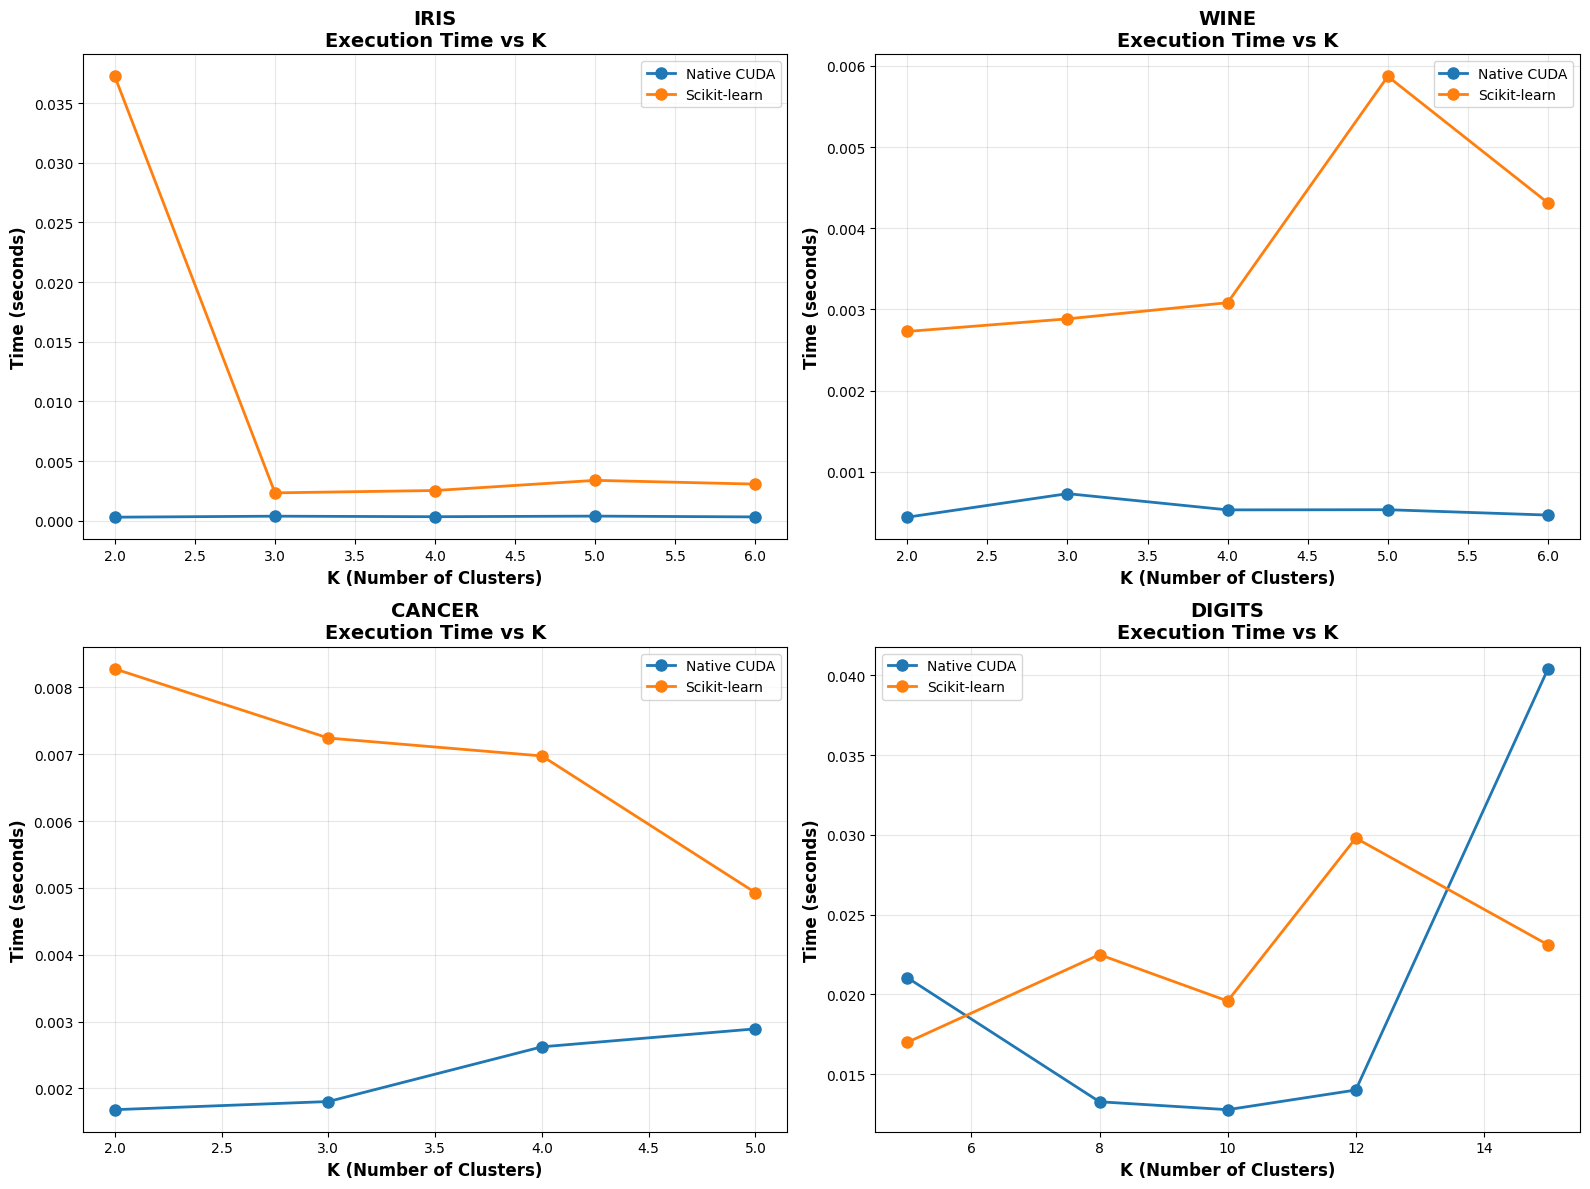

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (dataset_name, results_by_k) in enumerate(k_analysis_results.items()):
    ax = axes[idx]

    k_vals = sorted(results_by_k.keys())
    methods = list(results_by_k[k_vals[0]].keys())

    for method in methods:
        times = [results_by_k[k][method]['time'] for k in k_vals]
        if any(t > 0 for t in times):
            ax.plot(k_vals, times, marker='o', linewidth=2, markersize=8, label=method)

    ax.set_xlabel('K (Number of Clusters)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
    ax.set_title(f'{dataset_name.upper()}\nExecution Time vs K', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Visualization: Silhouette Score vs K (Quality Metric)

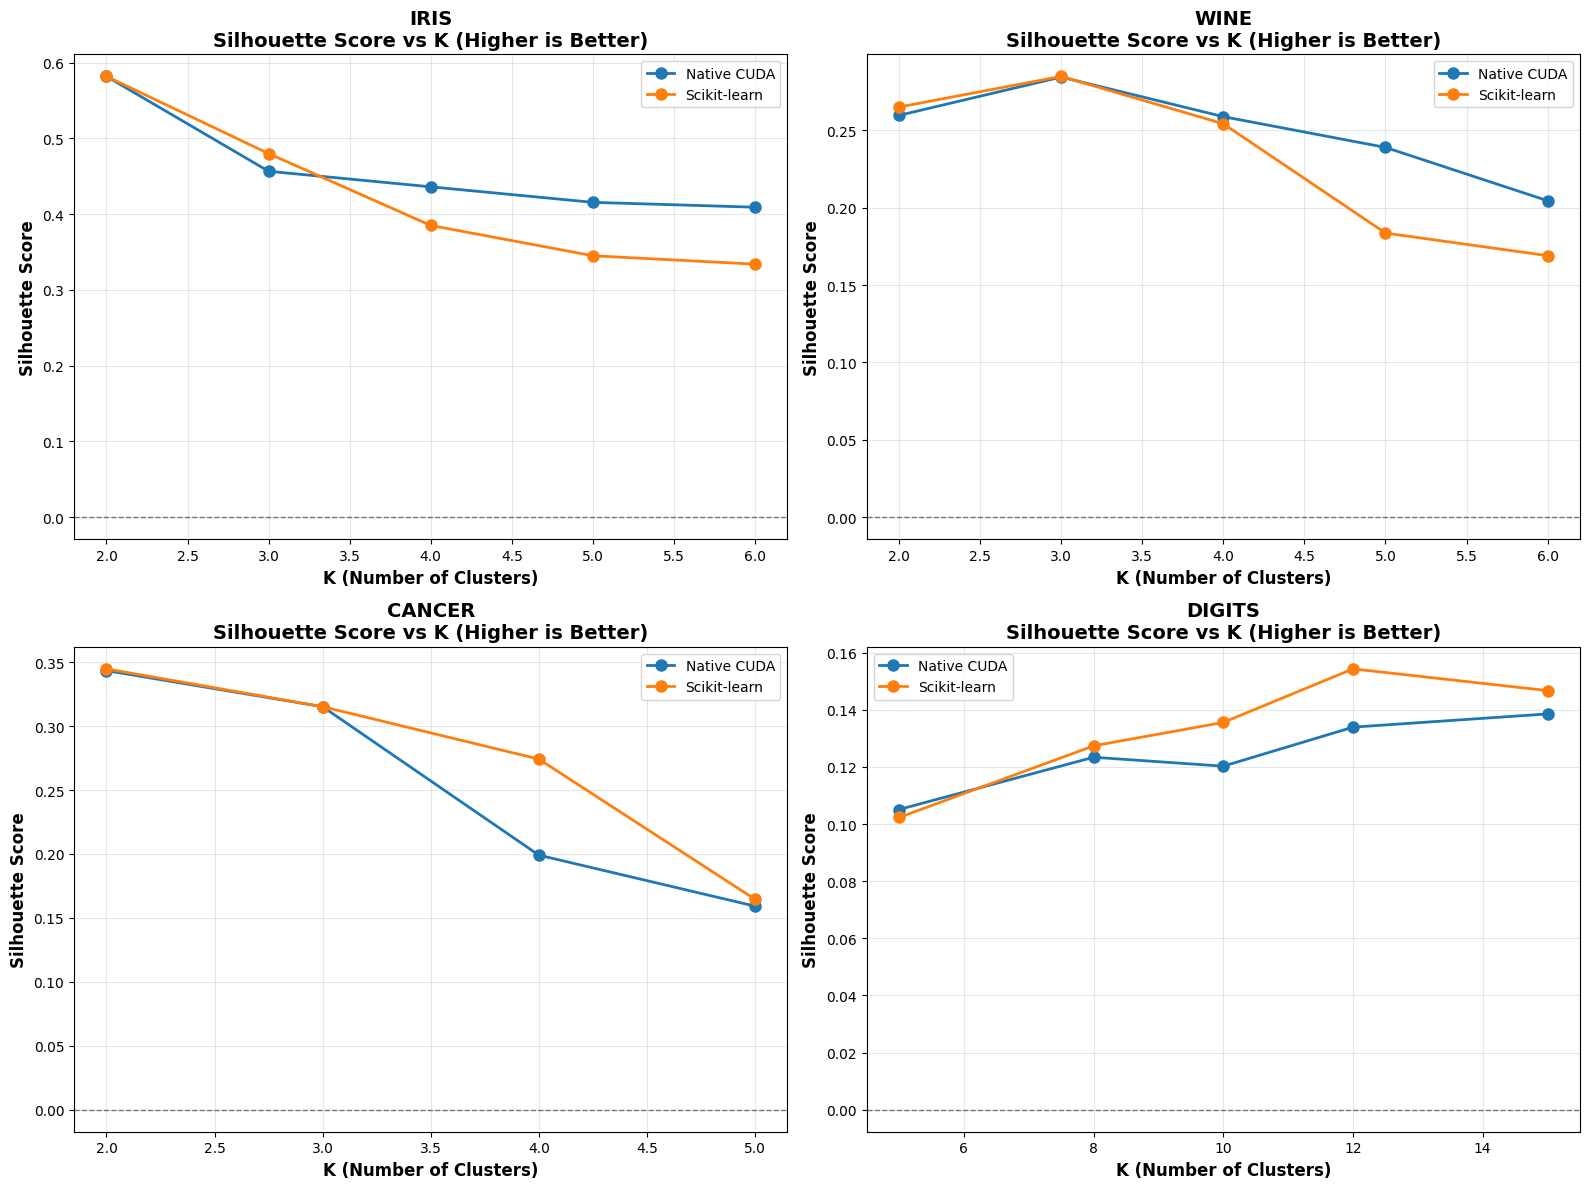

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (dataset_name, results_by_k) in enumerate(k_analysis_results.items()):
    ax = axes[idx]

    k_vals = sorted(results_by_k.keys())
    methods = list(results_by_k[k_vals[0]].keys())

    for method in methods:
        silhouettes = [results_by_k[k][method]['silhouette'] for k in k_vals]
        if any(s != 0 for s in silhouettes):
            ax.plot(k_vals, silhouettes, marker='o', linewidth=2, markersize=8, label=method)

    ax.set_xlabel('K (Number of Clusters)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
    ax.set_title(f'{dataset_name.upper()}\nSilhouette Score vs K (Higher is Better)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

## 7. Visualization: Inertia vs K

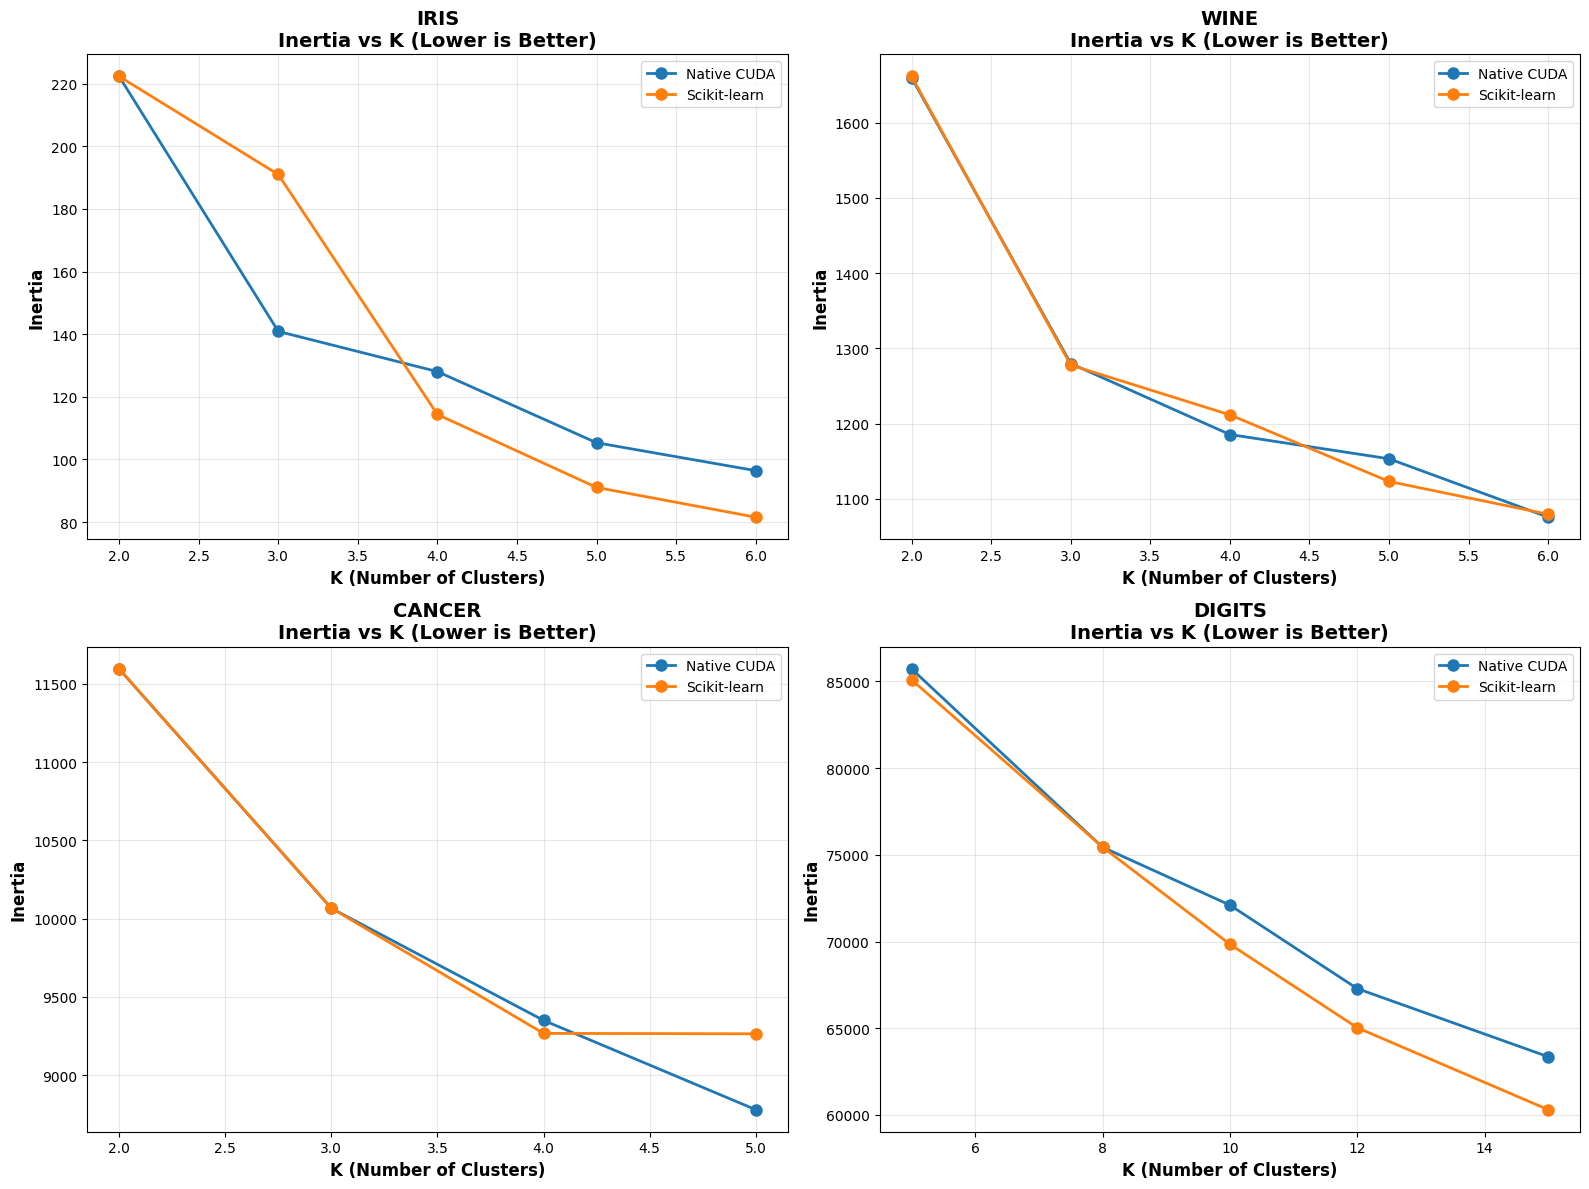

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (dataset_name, results_by_k) in enumerate(k_analysis_results.items()):
    ax = axes[idx]

    k_vals = sorted(results_by_k.keys())
    methods = list(results_by_k[k_vals[0]].keys())

    for method in methods:
        inertias = [results_by_k[k][method]['inertia'] for k in k_vals]
        if any(i > 0 for i in inertias):
            ax.plot(k_vals, inertias, marker='o', linewidth=2, markersize=8, label=method)

    ax.set_xlabel('K (Number of Clusters)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Inertia', fontsize=12, fontweight='bold')
    ax.set_title(f'{dataset_name.upper()}\nInertia vs K (Lower is Better)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Visualization: Speedup vs K

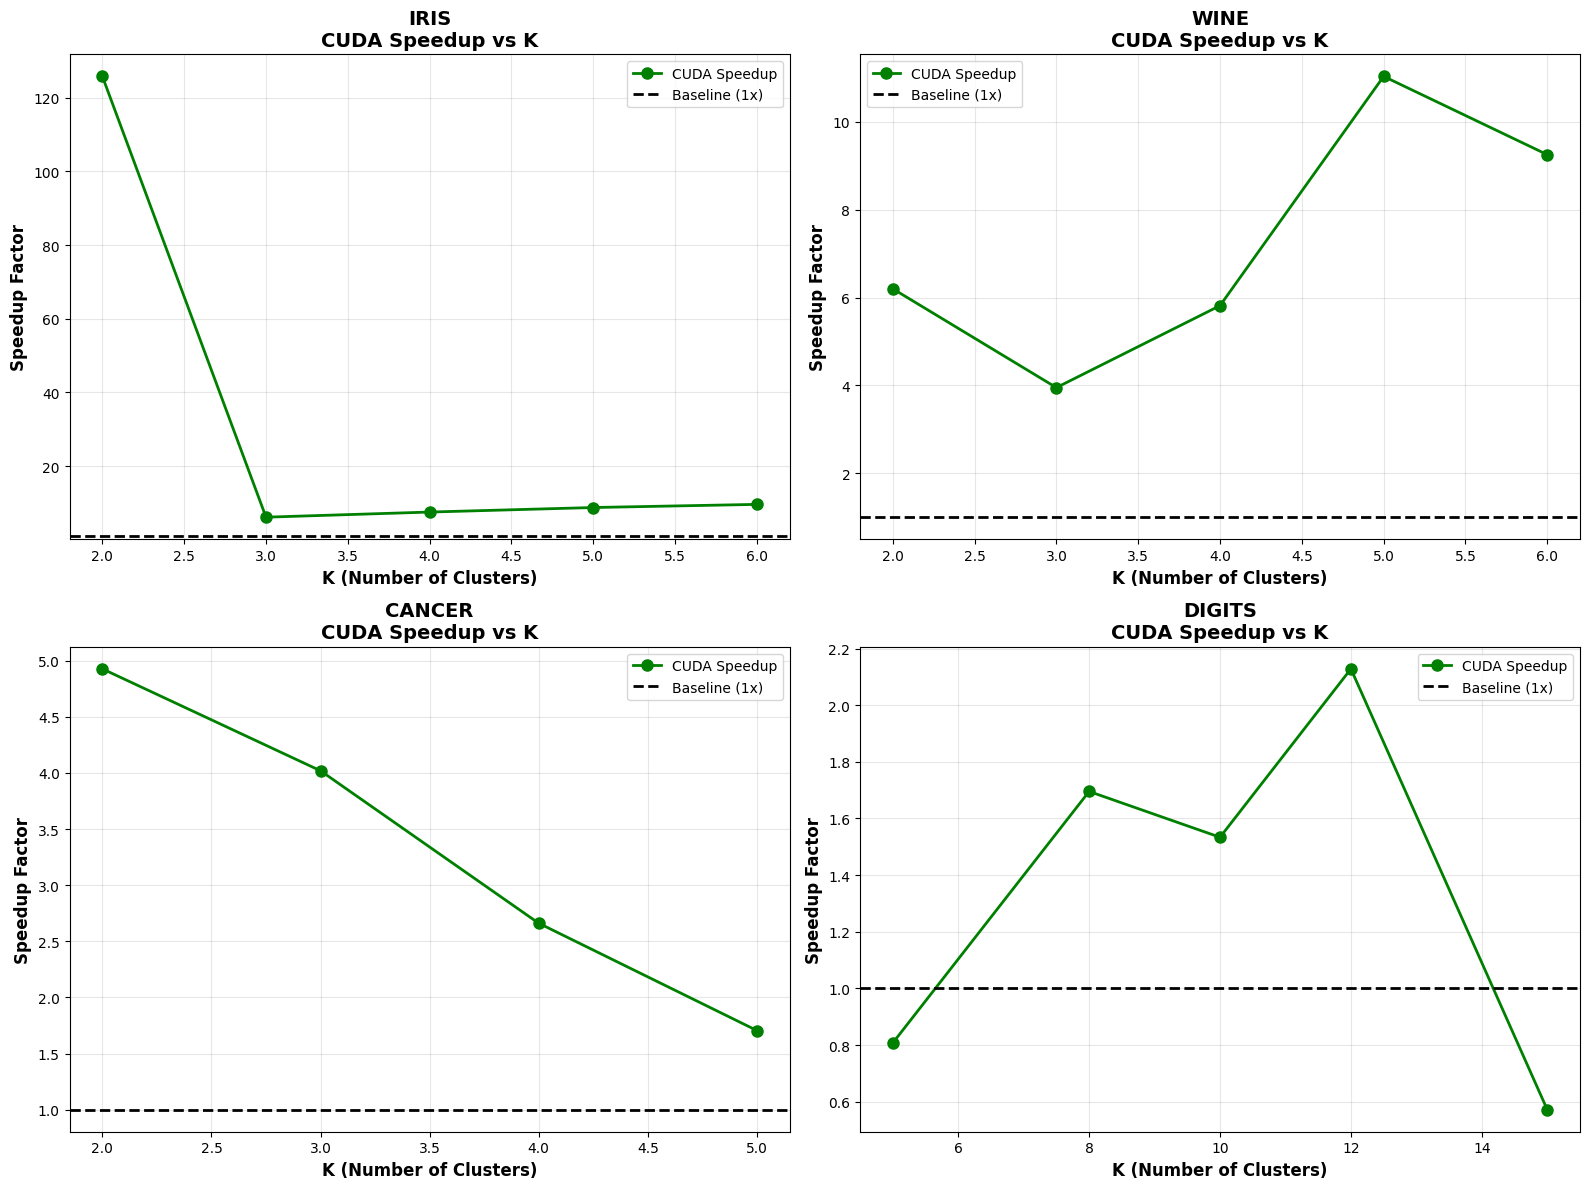

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (dataset_name, results_by_k) in enumerate(k_analysis_results.items()):
    ax = axes[idx]

    k_vals = sorted(results_by_k.keys())
    speedups = []

    for k in k_vals:
        sklearn_time = results_by_k[k]['Scikit-learn']['time']
        cuda_time = results_by_k[k]['Native CUDA']['time']
        if cuda_time > 0:
            speedups.append(sklearn_time / cuda_time)
        else:
            speedups.append(0)

    ax.plot(k_vals, speedups, marker='o', linewidth=2, markersize=8, color='green', label='CUDA Speedup')
    ax.axhline(y=1, color='black', linestyle='--', linewidth=2, label='Baseline (1x)')

    ax.set_xlabel('K (Number of Clusters)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Speedup Factor', fontsize=12, fontweight='bold')
    ax.set_title(f'{dataset_name.upper()}\nCUDA Speedup vs K', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Detailed Comparison Tables with Quality Metrics

In [10]:
for dataset_name, results_by_k in k_analysis_results.items():
    print(f"\n{'='*90}")
    print(f"{dataset_name.upper()} - K-VALUE ANALYSIS WITH QUALITY METRICS")
    print(f"{'='*90}\n")

    k_vals = sorted(results_by_k.keys())

    # Time table
    print("EXECUTION TIME (seconds):")
    time_data = []
    for k in k_vals:
        row = {'K': k}
        for method in results_by_k[k].keys():
            row[method] = f"{results_by_k[k][method]['time']:.4f}"
        time_data.append(row)
    df_time = pd.DataFrame(time_data)
    print(df_time.to_string(index=False))

    # Silhouette Score table
    print("\n\nSILHOUETTE SCORE (Higher is Better):")
    silhouette_data = []
    for k in k_vals:
        row = {'K': k}
        for method in results_by_k[k].keys():
            row[method] = f"{results_by_k[k][method]['silhouette']:.4f}"
        silhouette_data.append(row)
    df_silhouette = pd.DataFrame(silhouette_data)
    print(df_silhouette.to_string(index=False))

    # Inertia table
    print("\n\nINERTIA (Lower is Better):")
    inertia_data = []
    for k in k_vals:
        row = {'K': k}
        for method in results_by_k[k].keys():
            row[method] = f"{results_by_k[k][method]['inertia']:.2f}"
        inertia_data.append(row)
    df_inertia = pd.DataFrame(inertia_data)
    print(df_inertia.to_string(index=False))

    # Speedup table
    print("\n\nSPEEDUP (CUDA vs Scikit-learn):")
    speedup_data = []
    for k in k_vals:
        sklearn_time = results_by_k[k]['Scikit-learn']['time']
        cuda_time = results_by_k[k]['Native CUDA']['time']
        if cuda_time > 0:
            speedup = sklearn_time / cuda_time
            speedup_data.append({'K': k, 'Speedup': f"{speedup:.2f}x"})
        else:
            speedup_data.append({'K': k, 'Speedup': "N/A"})
    df_speedup = pd.DataFrame(speedup_data)
    print(df_speedup.to_string(index=False))


IRIS - K-VALUE ANALYSIS WITH QUALITY METRICS

EXECUTION TIME (seconds):
 K Native CUDA Scikit-learn
 2      0.0003       0.0372
 3      0.0004       0.0023
 4      0.0003       0.0025
 5      0.0004       0.0034
 6      0.0003       0.0031


SILHOUETTE SCORE (Higher is Better):
 K Native CUDA Scikit-learn
 2      0.5817       0.5817
 3      0.4565       0.4799
 4      0.4360       0.3850
 5      0.4155       0.3450
 6      0.4091       0.3339


INERTIA (Lower is Better):
 K Native CUDA Scikit-learn
 2      222.36       222.36
 3      140.90       191.02
 4      128.05       114.35
 5      105.33        91.05
 6       96.41        81.55


SPEEDUP (CUDA vs Scikit-learn):
 K Speedup
 2 125.79x
 3   6.14x
 4   7.53x
 5   8.76x
 6   9.62x

WINE - K-VALUE ANALYSIS WITH QUALITY METRICS

EXECUTION TIME (seconds):
 K Native CUDA Scikit-learn
 2      0.0004       0.0027
 3      0.0007       0.0029
 4      0.0005       0.0031
 5      0.0005       0.0059
 6      0.0005       0.0043


SILHOUETTE S

## 10. Quality Validation Summary

In [11]:
print("\n" + "="*90)
print("QUALITY VALIDATION: Comparing CUDA vs Scikit-learn")
print("="*90)
print("\nThis validates that both implementations produce similar clustering quality.\n")

for dataset_name, results_by_k in k_analysis_results.items():
    print(f"\n{dataset_name.upper()}:")

    k_vals = sorted(results_by_k.keys())

    for k in k_vals:
        cuda_sil = results_by_k[k]['Native CUDA']['silhouette']
        sklearn_sil = results_by_k[k]['Scikit-learn']['silhouette']

        if cuda_sil != 0 and sklearn_sil != 0:
            diff = abs(cuda_sil - sklearn_sil)
            diff_pct = (diff / abs(sklearn_sil)) * 100 if sklearn_sil != 0 else 0

            status = "✓ SIMILAR" if diff_pct < 10 else "⚠ DIFFERENT"
            print(f"  K={k}: CUDA={cuda_sil:.4f}, Sklearn={sklearn_sil:.4f}, Diff={diff:.4f} ({diff_pct:.1f}%) {status}")


QUALITY VALIDATION: Comparing CUDA vs Scikit-learn

This validates that both implementations produce similar clustering quality.


IRIS:
  K=2: CUDA=0.5817, Sklearn=0.5817, Diff=0.0000 (0.0%) ✓ SIMILAR
  K=3: CUDA=0.4565, Sklearn=0.4799, Diff=0.0233 (4.9%) ✓ SIMILAR
  K=4: CUDA=0.4360, Sklearn=0.3850, Diff=0.0509 (13.2%) ⚠ DIFFERENT
  K=5: CUDA=0.4155, Sklearn=0.3450, Diff=0.0705 (20.4%) ⚠ DIFFERENT
  K=6: CUDA=0.4091, Sklearn=0.3339, Diff=0.0751 (22.5%) ⚠ DIFFERENT

WINE:
  K=2: CUDA=0.2597, Sklearn=0.2650, Diff=0.0054 (2.0%) ✓ SIMILAR
  K=3: CUDA=0.2844, Sklearn=0.2849, Diff=0.0004 (0.2%) ✓ SIMILAR
  K=4: CUDA=0.2588, Sklearn=0.2542, Diff=0.0046 (1.8%) ✓ SIMILAR
  K=5: CUDA=0.2390, Sklearn=0.1836, Diff=0.0553 (30.1%) ⚠ DIFFERENT
  K=6: CUDA=0.2045, Sklearn=0.1690, Diff=0.0355 (21.0%) ⚠ DIFFERENT

CANCER:
  K=2: CUDA=0.3434, Sklearn=0.3447, Diff=0.0014 (0.4%) ✓ SIMILAR
  K=3: CUDA=0.3151, Sklearn=0.3152, Diff=0.0001 (0.0%) ✓ SIMILAR
  K=4: CUDA=0.1991, Sklearn=0.2742, Diff=0.0751 (27

## 11. Best K Analysis

In [12]:
print("\n" + "="*80)
print("BEST K VALUE ANALYSIS")
print("="*80)

for dataset_name, results_by_k in k_analysis_results.items():
    print(f"\n{dataset_name.upper()}:")

    k_vals = sorted(results_by_k.keys())
    methods = list(results_by_k[k_vals[0]].keys())

    for method in methods:
        # Find K with best silhouette score
        valid_k = [k for k in k_vals if results_by_k[k][method]['silhouette'] != 0]
        if valid_k:
            best_k_silhouette = max(valid_k, key=lambda k: results_by_k[k][method]['silhouette'])
            best_silhouette = results_by_k[best_k_silhouette][method]['silhouette']

            # Find K with lowest inertia
            best_k_inertia = min(valid_k, key=lambda k: results_by_k[k][method]['inertia'])
            best_inertia = results_by_k[best_k_inertia][method]['inertia']

            # Find K with best time
            best_k_time = min(valid_k, key=lambda k: results_by_k[k][method]['time'])
            best_time = results_by_k[best_k_time][method]['time']

            print(f"  {method}:")
            print(f"    Best Quality (Silhouette): K={best_k_silhouette} (Score={best_silhouette:.4f})")
            print(f"    Best Inertia: K={best_k_inertia} (Inertia={best_inertia:.2f})")
            print(f"    Fastest: K={best_k_time} (Time={best_time:.4f}s)")


BEST K VALUE ANALYSIS

IRIS:
  Native CUDA:
    Best Quality (Silhouette): K=2 (Score=0.5817)
    Best Inertia: K=6 (Inertia=96.41)
    Fastest: K=2 (Time=0.0003s)
  Scikit-learn:
    Best Quality (Silhouette): K=2 (Score=0.5817)
    Best Inertia: K=6 (Inertia=81.55)
    Fastest: K=3 (Time=0.0023s)

WINE:
  Native CUDA:
    Best Quality (Silhouette): K=3 (Score=0.2844)
    Best Inertia: K=6 (Inertia=1075.66)
    Fastest: K=2 (Time=0.0004s)
  Scikit-learn:
    Best Quality (Silhouette): K=3 (Score=0.2849)
    Best Inertia: K=6 (Inertia=1079.54)
    Fastest: K=2 (Time=0.0027s)

CANCER:
  Native CUDA:
    Best Quality (Silhouette): K=2 (Score=0.3434)
    Best Inertia: K=5 (Inertia=8778.42)
    Fastest: K=2 (Time=0.0017s)
  Scikit-learn:
    Best Quality (Silhouette): K=2 (Score=0.3447)
    Best Inertia: K=5 (Inertia=9263.41)
    Fastest: K=5 (Time=0.0049s)

DIGITS:
  Native CUDA:
    Best Quality (Silhouette): K=15 (Score=0.1386)
    Best Inertia: K=15 (Inertia=63356.39)
    Fastest: K=1